# Mask, Generator, Analysis
This notebook reads in images, creates the mask targets, and uses a custom generator to randomly rotate/flip the targets.

It also analyzes the model and loss output for a given run.

In [1]:
import glob
import cv2
import os
import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

import utils.make_density_map_charles as mdm
#import utils.make_density_map as mdm

## Preapre data

In [10]:
def get_im_cv2(path, img_width, img_height):
    img = cv2.imread(path)
    #resized = cv2.resize(img, (img_width, img_height))#, cv2.INTER_LINEAR)
    return img

def load_data(path, data_type, img_width, img_height):
    X, X_id, y = [], [], []
    minpix = 2                                  #minimum number of pixels for crater to count
    files = glob.glob('%s*.png'%path)
    minpix, maxpix = 2, 100                          #minimum pixels required for a crater to register in an image
    print "number of %s files are: %d"%(data_type,len(files))
    for f in files:
        flbase = os.path.basename(f)
        img = get_im_cv2(f,img_width,img_height) / 255.
        
        #experimenting with bigger contrast
        #img[img > 0.] = 1. - img[img > 0.] 
        minn, maxx = np.min(img[img>0]), np.max(img[img>0])
        low, hi = 0.1, 1    #low, hi rescaling values
        img[img>0] = low + (img[img>0] - minn)*(hi - low)/(maxx - minn) #linear re-scaling
        X.append(img)
        X_id.append(f)
        
        csv = pd.read_csv('%s.csv'%f.split('.png')[0])
        csv = csv[(csv['Diameter (pix)'] < maxpix) & (csv['Diameter (pix)'] > minpix)]
        target = mdm.make_mask(csv, img, binary=True, truncate=True, rings=True)
        #target = mdm.make_mask(csv, img, binary=True, truncate=True, rings=True)
        #target = mdm.make_circlering_mask(csv, img, binary=True, truncate=True)
        #target = mdm.make_mask(csv, img, binary=True, rings=True, ringwidth=1, truncate=True)
        y.append(target)
    return  X, y, X_id

def read_and_normalize_data(path, img_width, img_height, data_flag):
    if data_flag == 0:
        data_type = 'train'
    elif data_flag == 1:
        data_type = 'test'
    data, target, id = load_data(path, data_type, img_width, img_height)
    data = np.array(data).astype('float32')     #convert to numpy, convert to float
    print('%s shape:'%data_type, data.shape)
    return data, target, id

#save target no border for Hough circles
def save_image(data, cm, fn):
    sizes = np.shape(data)
    height = float(sizes[0])
    width = float(sizes[1])
    fig = plt.figure()
    fig.set_size_inches(width/height, 1, forward=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(data, cmap=cm)
    plt.savefig(fn, dpi = height) 

In [12]:
dim = 256
train_data, train_target, train_id = read_and_normalize_data('ds4/Train_ds4_msk/', dim, dim, 0)
test_data, test_target, test_id = read_and_normalize_data('ds4/Test_ds4_msk/', dim, dim, 0)

number of train files are: 20
('train shape:', (20, 256, 256, 3))
number of train files are: 20
('train shape:', (20, 256, 256, 3))


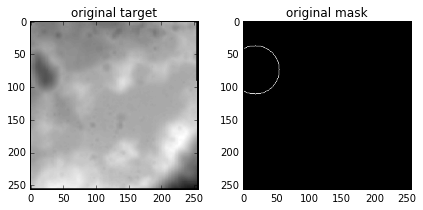

In [19]:
i=15
f, (ax1, ax2) = plt.subplots(1,2, figsize=[7, 3])
ax1.imshow(test_data[i], origin='upper')
ax1.set_title('original target')
ax2.imshow(test_target[i].reshape(dim,dim), origin='upper', cmap="Greys_r")
ax2.set_title('original mask')
#ax3.plot(train_target[i].reshape(300*300,1))
#ax3.set_title('original mask')
#plt.savefig("moon_exmask.png")

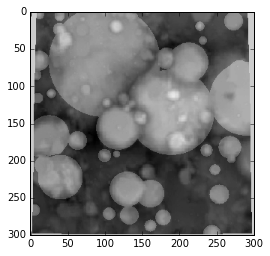

In [45]:
i=0
plt.imshow(1-train_data[i], origin='upper')
plt.imshow(train_target[i].reshape(300,300), origin='upper', cmap="Greys_r", alpha=0.2)
plt.savefig("moon_exmask.png")

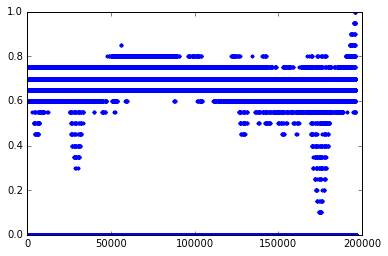

In [45]:
i=16
plt.plot(train_data[i].reshape(dim*dim*3,1), '.', label='ground truth pixel values')

## Testing that MAE/MSE is doing the right thing for both 2D and 3D

In [7]:
a=0
b = np.roll(train_target,1,axis=0)  #shift array by 1
for i in range(len(train_target)-1):
   summ = np.sum((train_target[i] - b[i+1])**2)
   a += summ
print a  #should get 0

#print np.sum((train_target[0:-1] - b[1:])**2), np.sum((train_target - b)**2)

0.0


## Load model and evaluate its performance

In [20]:
from keras.models import load_model

Using TensorFlow backend.


In [4]:
ext = "rings"    #rings or circlerings
train_data=np.load('training_set/train_data_%s_sample.npy'%ext).astype('float32')
train_target=np.load('training_set/train_target_%s_sample.npy'%ext).astype('float32')
test_data=np.load('test_set/test_data_%s_sample.npy'%ext).astype('float32')
test_target=np.load('test_set/test_target_%s_sample.npy'%ext).astype('float32')

In [32]:
#filename = 'models/FCNforkskip_%s_FL20.h5'%ext
#filename = 'models/FCNforkskip_sigmoidinv_FL10.h5'
filename = 'models/ds4_sigmoid_FL10.h5'
model = load_model(filename)
#model.summary()

In [ ]:
#do this on external cluster if large file
n,off=6,10
target = model.predict(test_data[off:(n+off)].astype('float32'))

In [23]:
err = np.sum((test_target[off:(n+off)] - target)**2) / (n*300*300)
err

0.0014333333333333333

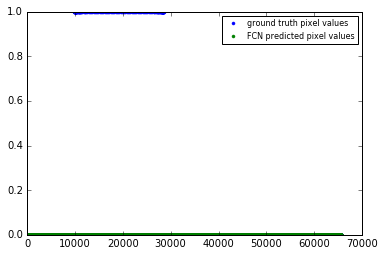

In [26]:
i=0
dim = 256
plt.plot(test_target[off+i].reshape(dim*dim,1), '.', label='ground truth pixel values')
plt.plot(target[i].reshape(dim*dim,1), '.', label='FCN predicted pixel values')
plt.legend(fontsize=8, numpoints=1)

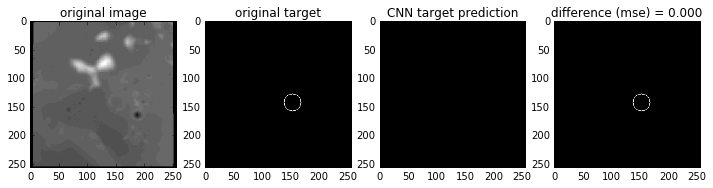

In [31]:
i=4

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=[12, 8])
ax1.imshow(test_data[off+i], origin='upper', cmap="Greys_r")
ax2.imshow(test_target[off+i], origin='upper', cmap="Greys_r")
ax3.imshow(target[i], origin='upper', cmap="Greys_r")
ax4.imshow(test_target[off+i] - target[i], origin='upper', cmap="Greys_r")
ax1.set_title('original image')
ax2.set_title('original target')
ax3.set_title('CNN target prediction')
diff = np.sum((test_target[i] - target[i])**2)/(300*300)
ax4.set_title('difference (mse) = %.3f'%diff)
plt.savefig('output_dir/images/%s_%d.png'%(os.path.basename(filename).split('.h5')[0],i))
#save_image(target[i], "Greys_r", 'output_dir/images/%s_%d_target.png'%(os.path.basename(filename).split('.h5')[0],i))

## Plot loss vs. epoch

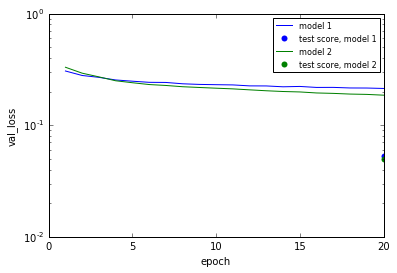

In [17]:
filename = 'output_dir/largefilters_sigmoid.txt'
#filename = 'models/good_models/FCNforkskip_imggen_lmbda0.0e+00.txt'

epoch_score, N_models = [], 0
lines = open(filename, 'r').readlines()
for line in lines:
    if "val_loss:" in line:
        epoch_score.append(float(line.split('val_loss:')[1]))
    elif "Test Score is" in line:
        N_models += 1
        test_score, n_epochs = float(line.split('Test Score is')[1]), len(epoch_score)
        p = plt.plot(np.arange(n_epochs)+1, epoch_score, label='model %d'%N_models)
        plt.plot(n_epochs, test_score, 'o', color=p[0].get_color(), mew=0, label='test score, model %d'%N_models)
        plt.legend(fontsize=8, numpoints=1)
        epoch_score = []

plt.plot(np.arange(len(epoch_score))+1, epoch_score)
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.yscale('log')

## Bilinear Upsampling Testing

In [12]:
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Flatten, Reshape
from keras.layers import AveragePooling2D, merge, Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
from keras.regularizers import l2
from keras import backend as K
K.set_image_dim_ordering('tf')
from utils.BilinearUpSampling import *

In [38]:
img_input = Input(batch_shape=(None, 300, 300, 3))
x = BilinearUpSampling2D(size=(2, 2))(img_input)
#x = UpSampling2D(size=(2, 2))(img_input)
model = Model(input=img_input, output=x)

In [39]:
#test_pred = model.predict(test_target.reshape(50,300,300,1)).reshape(50,600,600)
test_pred = model.predict(test_data)

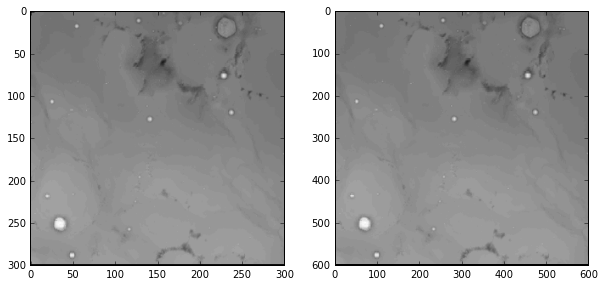

In [40]:
i=0
f, (ax1, ax2) = plt.subplots(1, 2, figsize=[10, 6])
ax1.imshow(test_data[i], origin='upper', cmap="Greys_r")
ax2.imshow(test_pred[i], origin='upper', cmap="Greys_r")

## Custom Image Generator

In [22]:
def custom_image_generator(data, target, batch_size=2):
    np.random.seed(0)
    L, W = data[0].shape[0], data[0].shape[1]
    while True:
        for i in range(0, len(data), batch_size):
            d, t = data[i:i+batch_size].copy(), target[i:i+batch_size].copy() #most efficient for memory?
            
            #horizontal/vertical flips
            for j in np.where(np.random.randint(0,2,batch_size)==1)[0]:
                d[j], t[j] = np.fliplr(d[j]), np.fliplr(t[j])                 #left/right 
            for j in np.where(np.random.randint(0,2,batch_size)==1)[0]:
                d[j], t[j] = np.flipud(d[j]), np.flipud(t[j])                 #up/down
                
            #random up/down and left/right pixel shifts
            npix = 10
            h = np.random.randint(-npix,npix+1,batch_size)                         #horizontal shift
            v = np.random.randint(-npix,npix+1,batch_size)                         #vertical shift
            r = np.random.randint(0,4,batch_size)                                  #random 90 degree rot
            for j in range(batch_size):
                d[j] = np.pad(d[j], ((npix,npix),(npix,npix),(0,0)), mode='constant')[npix+h[j]:L+h[j]+npix,npix+v[j]:W+v[j]+npix,:] 
                t[j] = np.pad(t[j], (npix,), mode='constant')[npix+h[j]:L+h[j]+npix,npix+v[j]:W+v[j]+npix]
                d[j], t[j] = np.rot90(d[j],r[j]), np.rot90(t[j],r[j])
            yield (d, t)

In [23]:
#Manipulate the first n_images in the training set
batch_size = 10
images = []
for batch in custom_image_generator(train_data,train_target,batch_size):
    images.append(batch)
    break 

NameError: name 'images' is not defined

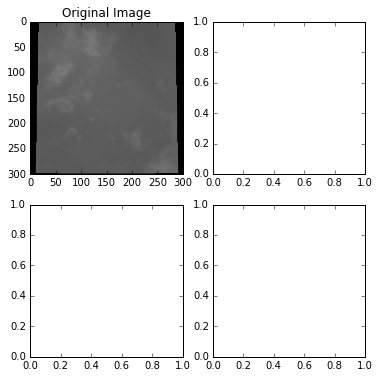

In [4]:
i=33      #i < n_images

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[6, 6])

ax1.imshow(train_data[i], origin='upper', cmap="Greys_r")
ax1.set_title('Original Image')

ax2.imshow(images[0][0][i], origin='upper', cmap="inferno")
ax2.set_title('Modified Image')


ax3.imshow(train_target[0][:][None], origin='upper', cmap="Greys_r")
#ax3.imshow(train_target[i].reshape(300,300), origin='upper', cmap="Greys_r")
ax3.set_title('Original Mask')

ax4.imshow(images[0][1][i].reshape(300,300), origin='upper', cmap="inferno")
ax4.set_title('Modified Mask')

#plt.savefig('sample.png')